In [1]:
import pandas 
import numpy 
import matplotlib.pyplot 
import torch
from src import tokenize
from CustomDatasets.PeptidesWithRetentionTimes import PeptidesWithRetentionTimes
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
class TunableAttentionRegression(torch.nn.Module):
    def __init__(self, input_size = 2707, hidden_size = 64,
                output_size = 1, numberOfHeads = 16) -> None:
        super(TunableAttentionRegression, self).__init__()
        self.embedding = torch.nn.Embedding(input_size, 32)
        self.lstm = torch.nn.LSTM(32, hidden_size, batch_first=True)
        self.attention = torch.nn.MultiheadAttention(hidden_size, num_heads=numberOfHeads, batch_first=True) #https://pytorch.org/docs/stable/generated/torch.ao.nn.quantizable.MultiheadAttention.html#multiheadattention
        self.linear1 = torch.nn.Linear(hidden_size*200, output_size, dtype=torch.float32)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x) -> torch.Tensor:
        # print(x.shape)
        x = x.view(x.size(0), x.size(2)*2)
        # print(x.shape)
        embedded = self.embedding(x)
        # print(embedded.shape)
        # embedded = embedded.view(*x.size(), -1) #to make it 3D
        lstm_out, _ = self.lstm(embedded)
        # print(lstm_out.shape)
        # lstm_out = lstm_out.permute(1, 0, 2)  # [seq_len, batch, hidden_size]
        # print(lstm_out.shape)
        query = lstm_out.permute(0, 1, 2)
        key = lstm_out.permute(0, 1, 2)
        value = lstm_out.permute(0, 1, 2)
        # print(query.shape, key.shape, value.shape)
        attention_output, _ = self.attention(query, key, value)
        # print(attention_output.shape)
        attention_output_as_2d = attention_output.reshape(attention_output.size(0), attention_output.size(1)*attention_output.size(2))
        # print(attention_output_as_2d.shape)
        output = self.linear1(attention_output_as_2d)
        # print(output.shape)
        # print(output)
        return output

In [3]:
def get_datasets_all():
    '''
    Returns train, validation, and testing datasets (0.8, 0.1, 0.1)
    '''
    vocab = tokenize.readVocabulary("C:\\Users\\elabo\\Documents\\GitHub\\RetentionTimeEstimators\\vocab.csv")
    data = pandas.read_csv("C:\\Users\\elabo\\Documents\\MannPeptideResults\\CalibratorTestingMultipleFilesSmallFiltered.csv",
                            index_col=None, header=0, usecols=["FullSequence", "Mean"])
    preTokens = tokenize.getPreTokens(data)
    tokens = tokenize.tokenizePreTokens(preTokens, vocab, 100, tokenize.TokenFormat.TwoDimensional)
    train, validateAndTest = train_test_split(tokens, test_size=0.2)
    validate, test = train_test_split(validateAndTest, test_size=0.5)

    trainingSequences = []
    trainingRetentionTimes = []
    for i in train:
        trainingSequences.append(i[0])
        trainingRetentionTimes.append(i[1])

    validationSequences = []
    validationRetentionTimes = []
    for i in validate:
        validationSequences.append(i[0])
        validationRetentionTimes.append(i[1])

    testingSequences = []
    testingRetentionTimes = []
    for i in test:
        testingSequences.append(i[0])
        testingRetentionTimes.append(i[1])

    trainingDataset = PeptidesWithRetentionTimes(trainingSequences, trainingRetentionTimes)
    testingDataset = PeptidesWithRetentionTimes(testingSequences, testingRetentionTimes)
    validationDataset = PeptidesWithRetentionTimes(validationSequences, validationRetentionTimes)

    return trainingDataset, validationDataset, testingDataset

In [14]:
#training data/ validation data
trainingDatasets, validationDatasets, testingDatasets = get_datasets_all()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the model
model = TunableAttentionRegression(hidden_size=64, numberOfHeads=8).to(device)
# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Create the loss function
criterion = torch.nn.MSELoss().to(device)

# Create the training data loader
trainingDataLoader = torch.utils.data.DataLoader(trainingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

validationDataLoader = torch.utils.data.DataLoader(validationDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

testinDataLoader = torch.utils.data.DataLoader(testingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)

c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence = str(row[0])
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.append((sequence, row[1]))
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.

In [15]:
len(trainingDatasets), len(validationDatasets), len(testingDatasets)

(131472, 16434, 16434)

In [17]:
# Train the model
model.train()
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(trainingDataLoader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print(inputs[:,0].shape, labels.shape)
        outputs = model(inputs.to(device)).to(device).squeeze()
        # print(outputs, labels.shape)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.5f" % (epoch + 1, i + 1,
                                            running_loss / epoch_steps))
            running_loss = 0.0

    # Validation loss
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(validationDataLoader):
        with torch.no_grad():
            inputs, labels = data
            labels = labels.float()

            outputs = model(inputs.to(device)).to(device).squeeze()
            total += labels.size(0)
            correct += (outputs.to(device) == labels.to(device)).sum().item()

            loss = criterion(outputs.to(device), labels.to(device))
            val_loss += loss.cpu().numpy()
            val_steps += 1
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}, Loss: {val_loss:.5f}')
    #save the model from this epoch
    torch.save(model.state_dict(), "7thTry_model_hs_64_droput_epoch_{}.pt".format(epoch))

[1,  2000] loss: 225.77781
[1,  4000] loss: 115.65523
Epoch 1, Loss: 129147.01966
[2,  2000] loss: 231.25130
[2,  4000] loss: 113.21401
Epoch 2, Loss: 118097.98022
[3,  2000] loss: 230.12471
[3,  4000] loss: 109.77344
Epoch 3, Loss: 125951.17677
[4,  2000] loss: 204.89047
[4,  4000] loss: 98.80356
Epoch 4, Loss: 107142.03912
[5,  2000] loss: 196.91452
[5,  4000] loss: 100.06096
Epoch 5, Loss: 121047.67774
[6,  2000] loss: 195.73521
[6,  4000] loss: 99.22189
Epoch 6, Loss: 110564.64948
[7,  2000] loss: 195.30321
[7,  4000] loss: 97.84840
Epoch 7, Loss: 105674.79318
[8,  2000] loss: 194.78635
[8,  4000] loss: 97.33789
Epoch 8, Loss: 107657.30745
[9,  2000] loss: 190.37126
[9,  4000] loss: 99.79791
Epoch 9, Loss: 105978.79414
[10,  2000] loss: 191.92626
[10,  4000] loss: 96.96347
Epoch 10, Loss: 107754.67973
[11,  2000] loss: 188.20747
[11,  4000] loss: 98.34697
Epoch 11, Loss: 111111.95260
[12,  2000] loss: 175.93761
[12,  4000] loss: 88.25027
Epoch 12, Loss: 102589.13218
[13,  2000] los

In [18]:
#Test model and get accuracy
testinDataLoader = torch.utils.data.DataLoader(testingDatasets,
                                                batch_size=32,
                                                shuffle=True, drop_last=True)
test_loss = 0.0
test_steps = 0
total = 0
correct = 0
# model.load_state_dict(torch.load('secondTry_model_hs_32_epoch_5.pt'))
model.eval()
preds = []

# Test model and calculate accuracy
for i, data in enumerate(testinDataLoader):
    with torch.no_grad():
        inputs, labels = data

        outputs = model(inputs.to(device)).to(device)
        predicted = outputs
        preds.append((labels, predicted))

In [19]:
allPredictions = []
allLabels = []
for label, pred in preds:
    allPredictions.append(pred)
    allLabels.append(label)

In [20]:
flatPreds = torch.stack(allPredictions).tolist()
flatLabels = torch.stack(allLabels).tolist()

In [29]:
import matplotlib.pyplot 
flatPreds[0][0], flatLabels[0][0]

([39.526615142822266], 35.07108)

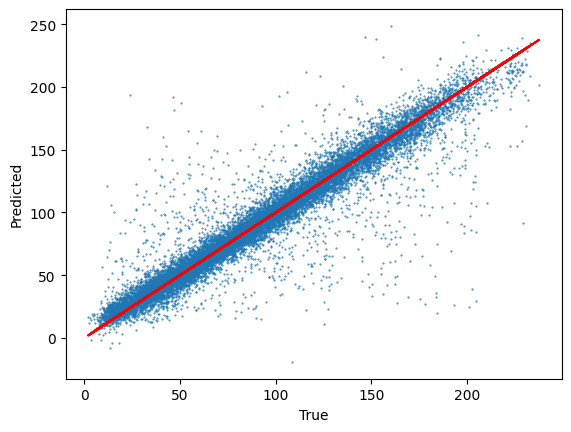

In [23]:
matplotlib.pyplot.scatter(flatLabels, flatPreds, s=0.2)
matplotlib.pyplot.plot(flatLabels, flatLabels, color='red')
matplotlib.pyplot.xlabel("True")
matplotlib.pyplot.ylabel("Predicted")
matplotlib.pyplot.show()

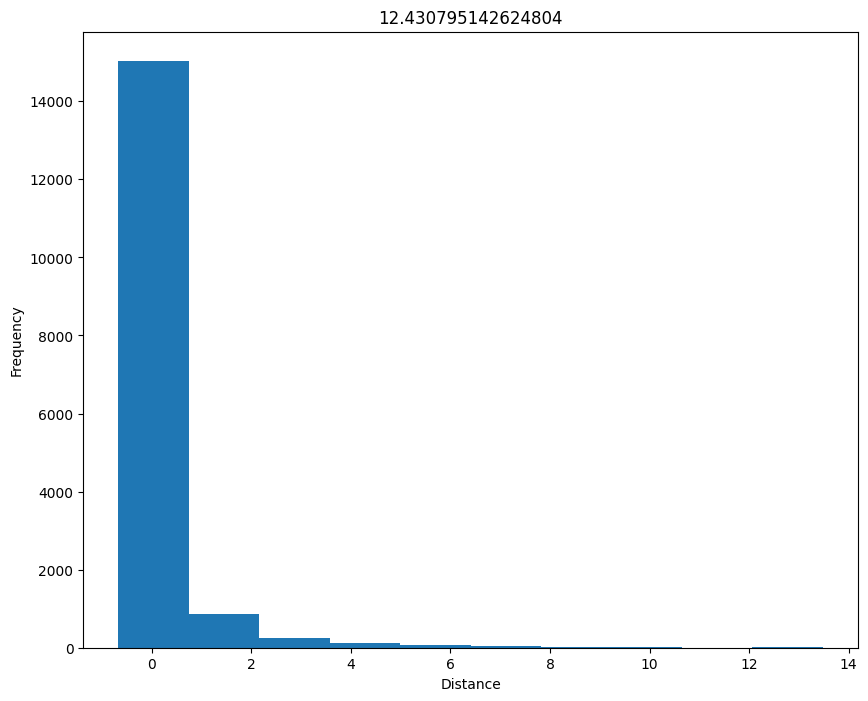

In [24]:
prds = []
for i in flatPreds:
    for k in i:
        for a in k:
            prds.append(a)

lbls = []
for i in flatLabels:
    for k in i:
        lbls.append(k)
sequentialArray = numpy.arange(0, len(prds), 1)
prds = numpy.vstack([prds, sequentialArray]).T
lbls = numpy.vstack([lbls, sequentialArray]).T
from sklearn.metrics.pairwise import paired_distances
dist = paired_distances(lbls, prds)
from scipy import stats
zScore = stats.zscore(dist)
xNorm = (dist - dist.mean()) / dist.std()
matplotlib.pyplot.hist(xNorm)
matplotlib.pyplot.title(dist.std())
matplotlib.pyplot.xlabel("Distance")
matplotlib.pyplot.ylabel("Frequency")
#increase size of plot
matplotlib.pyplot.gcf().set_size_inches(10, 8)
matplotlib.pyplot.show()

In [ ]:
flatPreds

[[[0.4393576979637146],
  [0.11827461421489716],
  [0.3520016670227051],
  [0.8351807594299316],
  [0.6237748265266418],
  [0.5575470328330994],
  [0.48996853828430176],
  [0.5443057417869568],
  [0.5679717063903809],
  [0.2872609496116638],
  [0.5530773997306824],
  [0.23171132802963257],
  [0.6488490700721741],
  [0.8151912689208984],
  [0.3221079707145691],
  [0.5238088369369507],
  [0.07346890866756439],
  [0.4963640868663788],
  [0.7082351446151733],
  [0.6237028241157532],
  [0.20620621740818024],
  [0.4443441331386566],
  [0.21110211312770844],
  [0.07342943549156189],
  [0.6742415428161621],
  [0.4955854117870331],
  [0.6306813359260559],
  [0.1295519918203354],
  [0.43538734316825867],
  [0.07421328127384186],
  [0.1018671840429306],
  [0.2329038381576538]],
 [[0.744813859462738],
  [0.30079689621925354],
  [0.49073904752731323],
  [0.24076204001903534],
  [0.48494309186935425],
  [0.3374997079372406],
  [0.6350061297416687],
  [0.6811186671257019],
  [0.3810671865940094],
  [

In [ ]:
allPredictions[0]

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], device='cuda:0')

In [ ]:
trainingDatasets.peptides

[array([[  10,   11,   11,   11,   16,    4,    9,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   0,    0, 2130, 2130,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         